# HW02 - Visualizing features of a pretrained VGG
In this homework, we are going to try to visualize what neurons encode through optimization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


First, load the pretrained VGG model with torchvision, and print the architecture of the model.

In [2]:
vgg_model = models.vgg16(pretrained=True)\
    .to(device)

print(vgg_model)

/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Part A - Visualizing the convolution filters

First, plot all the filters for the red channel of the first convolutional layer (there should be 64 filters in total). Can you find filters that seem to encode edges? Is this method useful for other layers?

In [3]:
### YOUR CODE HERE ###
first_conv_layer = vgg_model.features[0]  # The first convolutional layer
filters = first_conv_layer.weight.data  # Shape: (64, 3, 3, 3) -> (num_filters, channels, height, width)



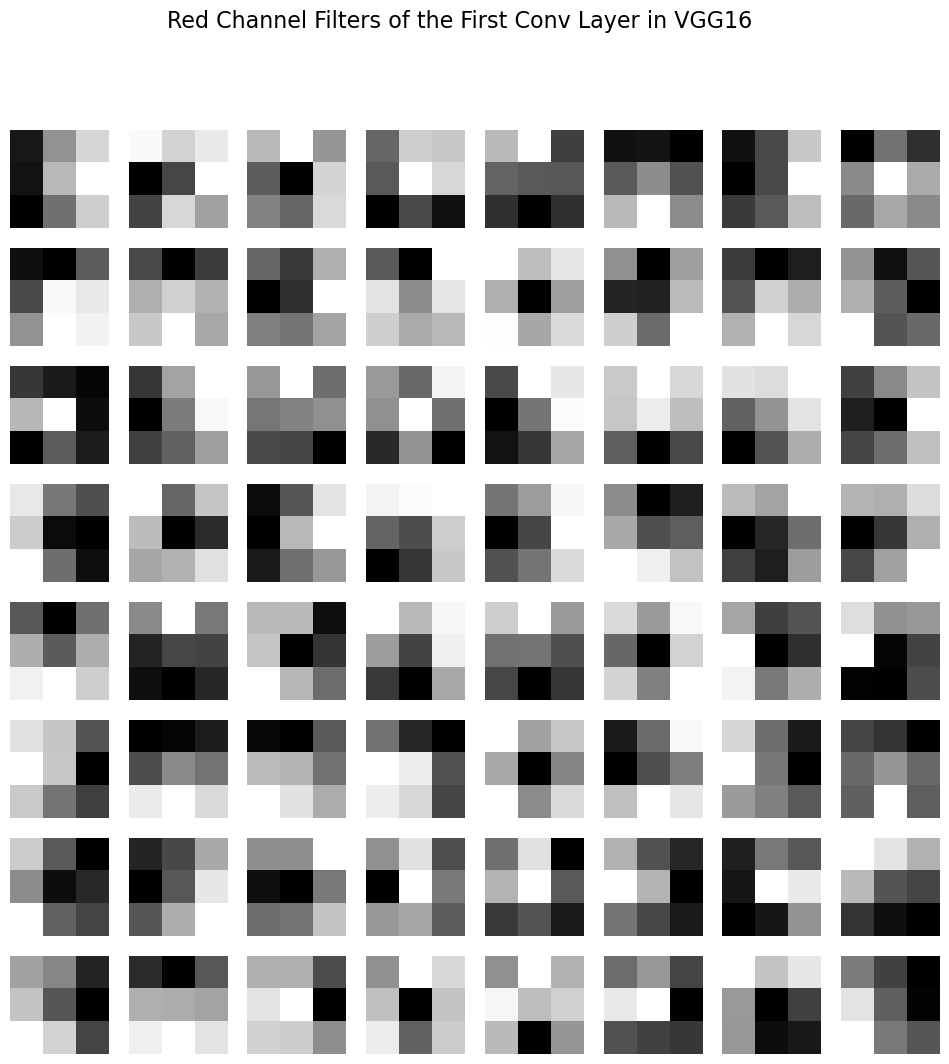

In [4]:
# Extract only the red channel (channel index 0)
red_channel_filters = filters[:, 0, :, :].cpu().numpy()  # Shape: (64, 3, 3)

# Plot the filters
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(red_channel_filters[i], cmap="gray")
    ax.axis("off")
plt.suptitle("Red Channel Filters of the First Conv Layer in VGG16", fontsize=16)
plt.show()

* Many of these filters encode edges. The key characteristic of an edge-detecting filter is the contrast between one side and the other, enabling it to capture intensity differences (edges) effectively. One of them would be for instance the first filter (shown below)

* This method is not useful for deeper layers, as they usually encode more complex patterns (such as eyes, faces, ...)

In [5]:
red_channel_filters[0]

array([[-0.5537306 ,  0.1427047 ,  0.5289615 ],
       [-0.58312404,  0.35655147,  0.76566225],
       [-0.69022113, -0.04801885,  0.48409155]], dtype=float32)

# Part B - Visualizing channel activations through image optimization
## B.1 - First implementation
Create a module `ChannelActivation(layer, channel)` that returns the average activation (i.e. output value) of channel `channel` of layer `layer` of the VGG features.

In [6]:
import torch
import torch.nn as nn

class ChannelActivation(nn.Module):
    def __init__(self, layer, channel):

        super(ChannelActivation, self).__init__()
        self.layer = layer
        self.channel = channel
        self.activation = None
        self.hook = self.layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.activation = output[:, self.channel, :, :].mean()

    def forward(self, x):
        return self.layer(x)

    def get_activation(self):
        return self.activation if self.activation is not None else None

    def remove_hook(self):
        
        self.hook.remove()


Our objective is to find which patterns are recognized by a given channel. To do so, we will follow the approach of [this Distill article](https://distill.pub/2017/feature-visualization/) and find images that lead to the highest possible channel activation.

First, create a random (colored) image of size 128x128, initialized with value at random between 0.4 and 0.6 (i.e. grey + small perturbation). Then, perform 200 steps of Adam (with lr=0.01) to maximize the activation of channel 4 of layer 1. Plot the image after 0, 10, 50, 100 and 200 iterations. You should see a pink saturated image with several horizontal lines, indicating that the channel probably recognizes horizontal edges.

**NB1:** Careful, by default, optimizers minimize their objective, not maximize it!

**NB2:** The parameters given to an optimizer should be on the cpu. If you use a gpu, you thus need to keep two versions of the image: 1) a cpu version given to the optimizer, and 2) a gpu version, created at each iteration of the optimization, and used to compute the gradient.

In [7]:
### YOUR CODE HERE ###
layer = vgg_model.features[1]  
channel = 4

In [8]:
activation_tracker = ChannelActivation(layer, channel)

# Initialize the image (128x128) with values between 0.4 and 0.6
image_cpu = torch.rand(1, 3, 128, 128) * 0.2 + 0.4  # (B, C, H, W)
image_cpu.requires_grad = True  # Enable gradient tracking

# Optimizer (maximize activation)
optimizer = torch.optim.Adam([image_cpu], lr=0.01)

# Store images at different iterations
iterations = [0, 10, 50, 100, 200]
saved_images = {}

# Optimization loop
for i in range(201):  # Run 200 iterations
    optimizer.zero_grad()  # Reset gradients
    image_gpu = image_cpu.to(device)  

    # Forward pass
    _ = vgg_model(image_gpu)

    # Compute loss (negative activation to maximize it)
    loss = -activation_tracker.get_activation()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Save images at specific iterations
    if i in iterations:
        with torch.no_grad():
            img = image_cpu.clone().detach().squeeze().permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)  # Ensure valid pixel range
            saved_images[i] = img

# Remove the hook after completion
activation_tracker.remove_hook()

Text(0.5, 0.8, 'Feature Visualization of Channel 4 (Layer 1)')

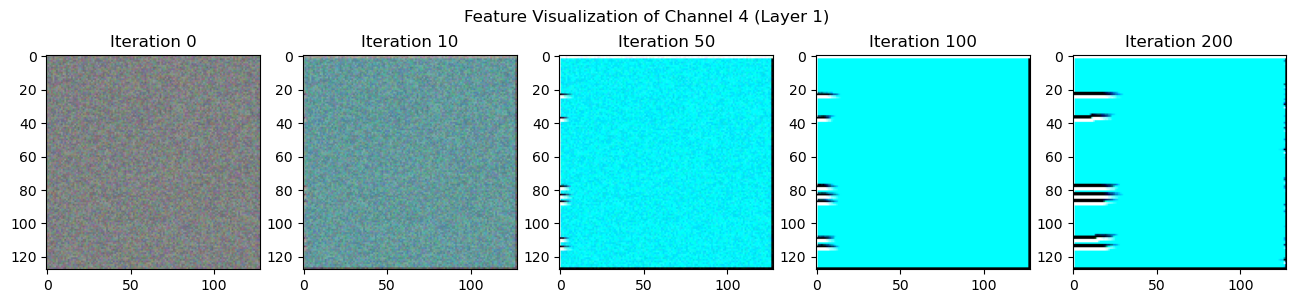

In [9]:
fig, axs = plt.subplots(1, len(iterations), figsize = (16,5))
for i, (iter_num, img) in enumerate(saved_images.items()):
    axs[i].imshow(img)
    axs[i].set_title(f"Iteration {iter_num}")
plt.suptitle("Feature Visualization of Channel 4 (Layer 1)", y = 0.8)

## B.2 - Improving stability with clipping and normalization
Compute the highest and lowest values of the image. What is the issue?

In [10]:
### YOUR CODE HERE ###
print(f"Maximum: {torch.max(image_cpu).item()}")
print(f"Minimum: {torch.min(image_cpu).item()}")


Maximum: 3.558767795562744
Minimum: -2.409818649291992


The problem is that the minimum tales a negative value, making it harder to normalize in the rrange [0,1] (or [0,255])

To avoid (over) saturation, clip the image pixels to $[0.2,0.8]$ after each optimization step using `input_image.data = input_image.data.clip(0.2, 0.8)`. You should now see several clear horizontal lines in a blue background.

In [11]:
### YOUR CODE HERE ###
activation_tracker = ChannelActivation(layer, channel)

# Initialize the image (128x128) with values between 0.4 and 0.6
image_cpu = torch.rand(1, 3, 128, 128) * 0.2 + 0.4  # (B, C, H, W)
image_cpu.requires_grad = True  # Enable gradient tracking

# Optimizer (maximize activation)
optimizer = torch.optim.Adam([image_cpu], lr=0.01)

# Store images at different iterations
iterations = [0, 10, 50, 100, 200]
saved_images = {}

# Optimization loop
for i in range(201): 
    optimizer.zero_grad()  # Reset gradients
    image_gpu = image_cpu.to(device)  

    # Forward pass
    _ = vgg_model(image_gpu)

    # Compute loss (negative activation to maximize it)
    loss = -activation_tracker.get_activation()

    # Backpropagation
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        image_cpu.data = torch.clamp(image_cpu.data, 0.2, 0.8)

    # Save images at specific iterations
    if i in iterations:
        with torch.no_grad():
            img = image_cpu.clone().detach().squeeze().permute(1, 2, 0).cpu().numpy()
            img = np.clip(img, 0, 1)  # Ensure valid pixel range
            saved_images[i] = img

# Remove the hook after completion
activation_tracker.remove_hook()

Text(0.5, 0.8, 'Feature Visualization of Channel 4 (Layer 1)')

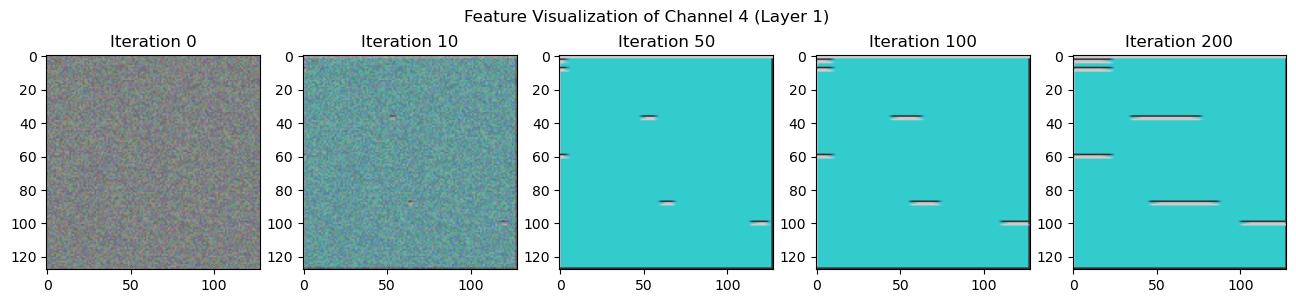

In [12]:
fig, axs = plt.subplots(1, len(iterations), figsize = (16,5))
for i, (iter_num, img) in enumerate(saved_images.items()):
    axs[i].imshow(img)
    axs[i].set_title(f"Iteration {iter_num}")
plt.suptitle("Feature Visualization of Channel 4 (Layer 1)", y = 0.8)

In [13]:
torch.max(image_cpu), torch.min(image_cpu)

(tensor(0.8000, grad_fn=<MaxBackward1>),
 tensor(0.2000, grad_fn=<MinBackward1>))

One issue with our current code, is that VGG was trained on **normalized** images, and thus is not adapted to our input image. To normalize the image, we will use **transforms**.

Create a function `create_activation_image(layer, channel, transform=None, image_size=128, show_steps=False)` that maximizes the corresponding channel activation on an image of size `image_size`, and first applies `transform` to the image before computing the gradient of the activation. The function should return the final image after 200 steps, and plot intermediate images for the steps 0,10,50,100,200 if `show_steps=True`.

Then, test your function with `transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`. Is this better? You should now see a horizontal pattern with lines.

In [14]:
### YOUR CODE HERE ###
def create_activation_image(
    layer, 
    channel, 
    transform=None, 
    image_size=128, 
    show_steps=False,
    layer_idx = ''
):
    """
    Creates an image that maximizes the activation of a given channel in a specific VGG layer.
    
    Parameters:
        layer (nn.Module): The layer to optimize the activation from.
        channel (int): The channel index to maximize.
        transform (torchvision.transforms.Compose or None): The transform applied before passing the image into the model.
        image_size (int): The size of the generated image (square).
        show_steps (bool): If True, plots intermediate images at steps 0, 10, 50, 100, and 200.

    Returns:
        np.array: The final optimized image.
    """

    # Initialize the ChannelActivation module
    activation_tracker = ChannelActivation(layer, channel)

    # Initialize the image (image_size x image_size) with values between 0.4 and 0.6
    image_cpu = torch.rand(1, 3, image_size, image_size) * 0.2 + 0.4
    image_cpu.requires_grad = True  # Enable gradient tracking

    # Optimizer (maximize activation)
    optimizer = torch.optim.Adam([image_cpu], lr=0.01)

    # Store images at different iterations
    iterations = [0, 10, 50, 100, 200]
    saved_images = {}

    # Optimization loop
    for i in range(201):  # Run 200 iterations
        optimizer.zero_grad()  # Reset gradients
        image_gpu = image_cpu.to(device)  # Move image to the same device as the model

        # Apply normalization transform if provided
        if transform:
            image_gpu_transformed = transform(image_gpu)
        else:
            image_gpu_transformed = image_gpu

        # Forward pass
        _ = vgg_model(image_gpu_transformed)

        # Compute loss (negative activation to maximize it)
        loss = -activation_tracker.get_activation()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Clip image pixels to [0.2, 0.8] to avoid oversaturation
        with torch.no_grad():
            image_cpu.data = torch.clamp(image_cpu.data, 0.2, 0.8)

        # Save images at specific iterations
        if show_steps and i in iterations:
            with torch.no_grad():
                img = image_cpu.clone().detach().squeeze().permute(1, 2, 0).cpu().numpy()
                img = np.clip(img, 0, 1)  # Ensure valid pixel range
                saved_images[i] = img

    activation_tracker.remove_hook()

    # Plot intermediate results if required
    if show_steps:
        fig, axes = plt.subplots(1, len(iterations), figsize=(16, 5))
        for i, iter_num in enumerate(iterations):
            axes[i].imshow(saved_images[iter_num])
            axes[i].set_title(f"Iteration {iter_num}")
            axes[i].axis("off")
        plt.suptitle(f"Feature Visualization of Channel {channel} (Layer {layer_idx})", y = 0.8)
        plt.show()

    # Return final optimized image
    return image_cpu.clone().detach().squeeze().permute(1, 2, 0).cpu().numpy()



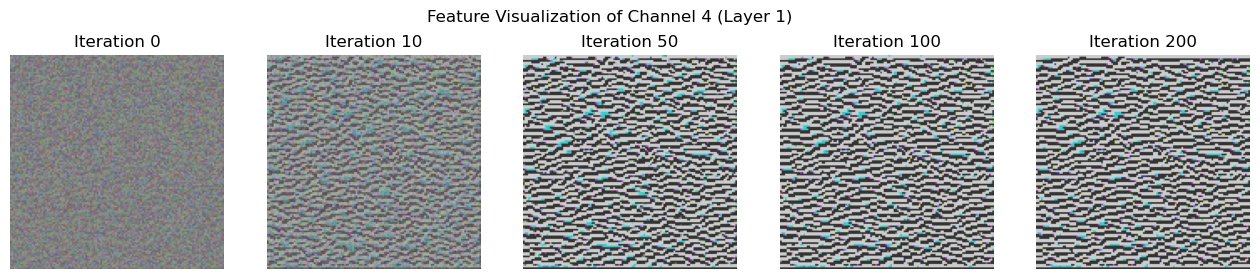

In [15]:
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

final_image = create_activation_image(layer=vgg_model.features[1], channel=4, transform=normalization, image_size=128, show_steps=True, layer_idx = 1)

Now test your function on channel 0 of layer 20. The pattern that appears should vagely resemble fish scales.

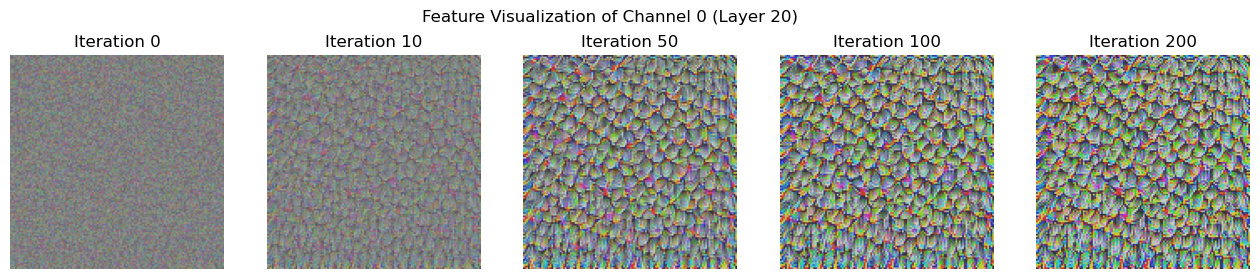

In [16]:
### YOUR CODE HERE ###

final_image_20 = create_activation_image(layer=vgg_model.features[20], channel=0, transform=normalization, image_size=128, show_steps=True, layer_idx = 20)

## B.3 - Transformation robustness
Large neural network are prone to adversarial attacks, i.e. a small well-crafted additive noise can dramatically change the output of the model, and thus lead to incorrect classification. For our purpose, this is an issue, as the optimization algorithm may find such very specific noise instead of more valuable visual patterns.

To avoid this issue and further improve our images, we are thus going to apply small random perturbations to the image before computing the gradient. This will prevent the optimizer from optimizing the noise, and overall increase the stability of our process.

To do so, add a composition of several transforms (before the normalization):

1.   A small pixel noise with `transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1))`
2.   A random affine transform with `transforms.RandomAffine(degrees=5, translate=(0.1,0.1), scale=(0.9,1.1))`
3.   A random crop of size 96 (to reduce the size of the image)
4.   Random local fluctations with `transforms.ElasticTransform(alpha=50.)`

Compare the activation images with and without these random transformations. Is the pattern more visible?



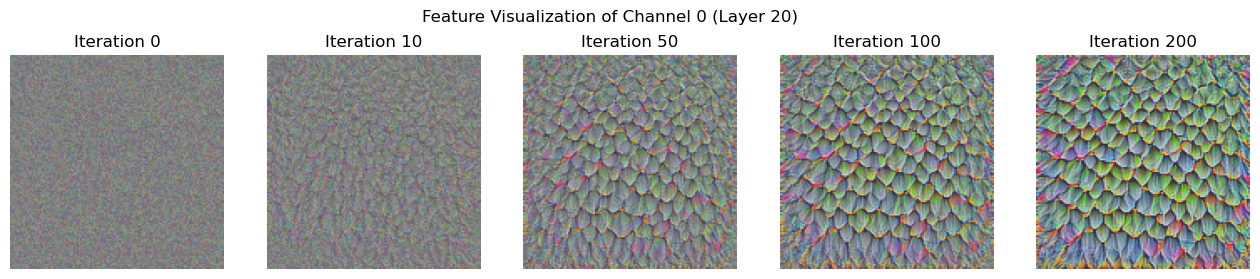

In [17]:
### YOUR CODE HERE ###

robust_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1)),  # Small pixel noise
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transform
    transforms.RandomCrop(96),  # Random crop of size 96
    transforms.ElasticTransform(alpha=50.0),  # Random local fluctuations
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

final_image_20 = create_activation_image(layer=vgg_model.features[20], channel=0, transform=robust_transform, image_size=128, show_steps=True, layer_idx = 20)

To see what the transformation is doing to an image, apply the random transformations (without normalization) to the following simple image, and show 5 randomly transformed images.

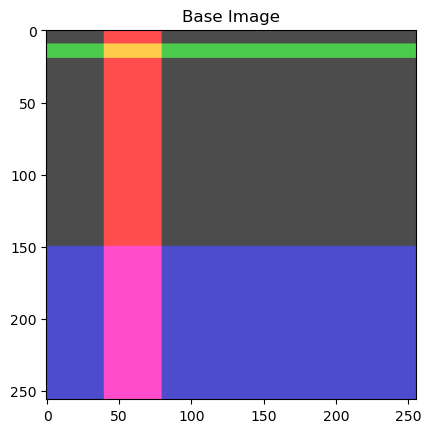

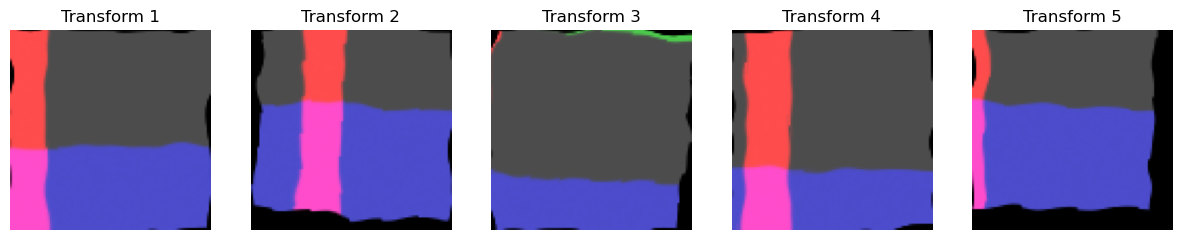

In [18]:
def tensor_to_image(tensor):
    tensor = tensor.clone().detach()
    tensor = tensor.permute(1, 2, 0).numpy()
    return np.clip(tensor, 0, 1)

sample_image = 0.3 * torch.ones(3, 256, 256)
sample_image[0,:,40:80] += 0.7
sample_image[1,10:20,:] += 0.5
sample_image[2,150:,:] += 0.5
plt.title("Base Image")
plt.imshow(tensor_to_image(sample_image))

### YOUR CODE HERE ###


# Create the sample image
sample_image = 0.3 * torch.ones(3, 256, 256)
sample_image[0, :, 40:80] += 0.7
sample_image[1, 10:20, :] += 0.5
sample_image[2, 150:, :] += 0.5

# Define random transformations (without normalization)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Lambda(lambda x: x + 0.001 * (2 * torch.rand_like(x) - 1)),  # Small pixel noise
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Random affine transform
    transforms.RandomCrop(96),  # Random crop of size 96
    transforms.ElasticTransform(alpha=50.0),  # Random local fluctuations
])

# Generate and display 5 transformed images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    transformed_image = transform(sample_image)
    axes[i].imshow(tensor_to_image(transformed_image))
    axes[i].axis("off")
    axes[i].set_title(f"Transform {i+1}")

plt.show()


## B.4 - Final visualization
Finally, show the activation images for the first 5 channels of layers [1, 10, 20, 30]. You should be able to see a gradual complexification of the patterns.

**PS1:** Our method seems unable to find meaningful patterns for the last layer. One issue is probably that the random crop imposes that all regions on the image look similar (as they all should have a high channel activation), thus preventing larger and more complex patterns to emerge from the optimization.

**PS2:** You can also try other layers and channels to find interesting patterns!

Layer 1
Layer 10
Layer 20
Layer 30


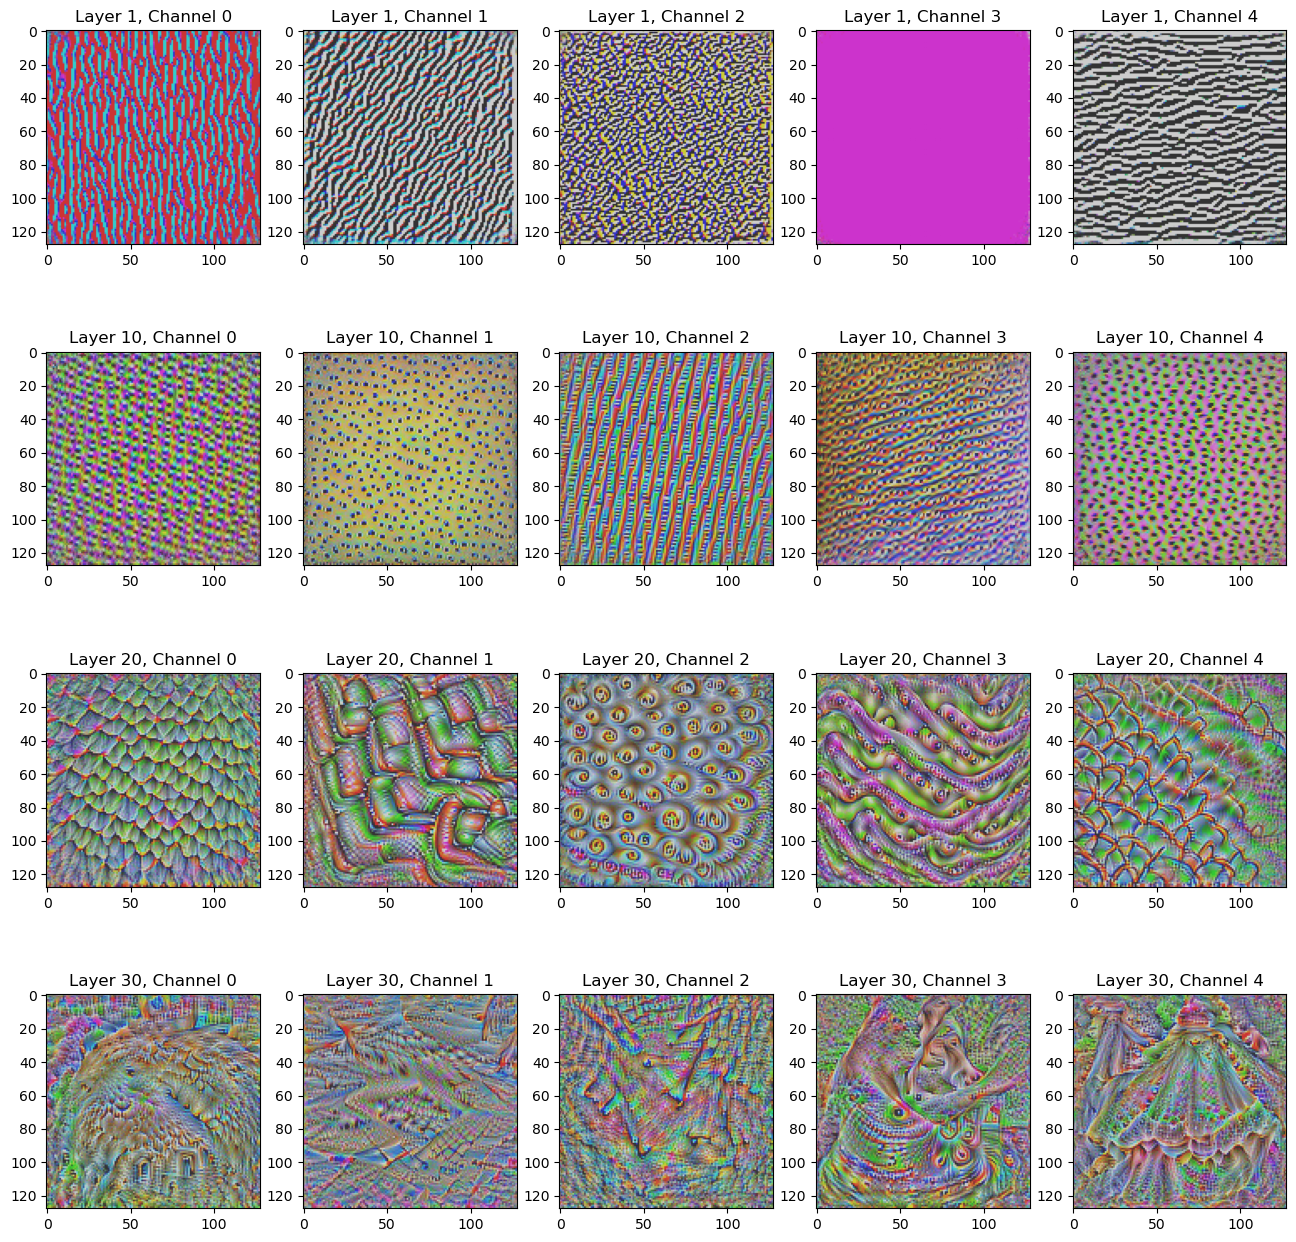

In [19]:
### YOUR CODE HERE ###

layers = [1, 10, 20, 30]
n_channels=5
fig, axs = plt.subplots(len(layers), n_channels, figsize = (16,16))


for i, layer_idx in enumerate(layers):
    print(f"Layer {layer_idx}")
    layer=vgg_model.features[layer_idx]

    for channel in range(n_channels):

        img=create_activation_image(layer,channel, transform=robust_transform, show_steps=False)
        axs[i, channel].imshow(img)
        axs[i, channel].set_title(f"Layer {layer_idx}, Channel {channel}")